In [1]:
# Standard library imports
import multiprocessing
import warnings
import pickle

# Third party imports
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from scipy.stats import norm, randint, uniform
from sklearn import metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.subsample import BlockBootstrap
from mapie.time_series_regression import MapieTimeSeriesRegressor
from xgboostlss.model import *
from xgboostlss.distributions import *
from xgboostlss.distributions.distribution_utils import DistributionClass
# Local application/library specific imports
from Preprocessing_singlebuild_with_artificial import Preprocessing
from Visualization_artificial import Visualization
import alarm_matrix_new
import alarm_matrix_new_withbackprop

# Supress warnings and pandas chained assignment
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba

## Building consumption anomaly detection: A comparative study of two probabilistic approaches 
Davor Stjelja, Vladimir Kuzmanovski, Risto Kosonen, Juha Jokisalo 


Aalto University

Granlund Oy

Vaisala Oyj

Nanjing Tech University


## Data can't be used at this moment, until we get permission to publish from building owners

Here are both dataset from the article, they were anonymized for the sake of privacy. If you want to use district heating dataset then uncomment everywhere where it says heating and comment the ones wich say electricity. If you want to check performance on dataset without anomaly use 'Consumption' two cells below, otherwise use 'm_Consumption'

### Data Load

In [1]:
# Uncomment dataset you want to use
# Heating
#ds = pd.read_pickle("HeatDataset_wAA.pkl")

# Elec
#ds = pd.read_pickle("ElecDataset_wAA.pkl")

### Aritifical anomalies

In [3]:
# If using real data use 'Consumption', if artificial anomalies use 'm_Consumption', drop the other
ds.drop(['Consumption'], axis=1, inplace=True)
ds.rename(columns={'m_Consumption':'Consumption'}, inplace=True)

# ds.drop(['m_Consumption'], axis=1, inplace=True)
# ds['m_bool'] = False

## periods for test

In [4]:
# # Anomaly periods are defined here, they are different for different dataset, uncomment one you want to use

# Heating
# anomaly_periods = {
#     'School 1': ['2020-02-01', '2020-03-31'],
#     'Senior home': ['2019-03-01', '2019-04-30'],
#     'School 2': ['2019-10-01', '2019-11-30'],
#     'School 3': ['2020-02-01', '2020-03-31'] ,
# }

# Elec 
anomaly_periods = {
    'University building': ['2019-06-01', '2019-06-30'],
    'Shopping mall 1': ['2021-02-01', '2021-03-31'],
    'Shopping mall 2': ['2020-10-01', '2020-11-30'],
    'Senior home': ['2021-09-01', '2021-10-31']
}

## Optimization & model parameters setting

In [5]:
# General hyperparams
alpha = 0.05         # confidence level    
quantiles = [alpha/2,       # quantiles to predict
             0.5,
             1-(alpha/2)] 

# Pre-optimized parameters - comprise for all
opt_params_lgbm={'learning_rate':0.037987557990657006, 'max_depth':27,
              'min_data_in_leaf':527, 'n_estimators':783, 'num_leaves':1786,
              'objective':'regression', 'random_state':59,
              'reg_alpha':0.16284813849651236, 'reg_lambda':0.4198737911470489}

opt_params_lss={'eta': 0.19262478591119223,
 'max_depth': 8,
 'gamma': 0.12743803499652331,
 'subsample': 0.9234424599017936,
 'colsample_bytree': 0.8222027451145232,
 'min_child_weight': 0.0001523605987501173,
 'booster': 'gbtree',
 'opt_rounds': 312}



## Methods

### EnbPI

#### Optimize hyperparameters

In [8]:
def optimize_EnbPI_hyperparameters(X_train,Y_train):
    # CV parameter search
    n_iter = 100
    n_splits = 10
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    lgbm_model = LGBMRegressor(random_state=random_state,objective='regression',boosting_type='gbdt',metric='rmse')
    lgbm_params = {"max_depth": randint(2, 30),'num_leaves':randint(200,5000),'n_estimators':randint(100,3000), "min_data_in_leaf": randint(100, 1000),'learning_rate':uniform(0,1),'reg_alpha':uniform(0,1),'reg_lambda':uniform(0,1),'subsample':uniform(0,1),'colsample_bytree':uniform(0,1)}
    cv_obj = RandomizedSearchCV(
        lgbm_model,
        param_distributions=lgbm_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=1,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, Y_train)
    model = cv_obj.best_estimator_
    return model

#### Blockbootstrap of dataset for EnbPI

In [9]:
# change n_resampling and length depending on dataset
cv_mapiets = BlockBootstrap(
    n_resamplings=150, length=3500, overlapping=False, random_state=59)

model = LGBMRegressor(**opt_params_lgbm)   


#### Train

In [10]:
Results_EnbPI=pd.DataFrame()
for building_id, period in anomaly_periods.items():
    Start_date=pd.Timestamp(period[0])
    End_date=pd.Timestamp(period[1])

    Test_Start=Start_date
    Train_End=Test_Start+DateOffset(days=-1)
    Train_Start=Test_Start+DateOffset(months=-12)
    Test_End=End_date
    Results_temp=pd.DataFrame()
    ds_build=ds[ds.ObjectName == building_id]
    X_train,X_test,Y_train,Y_test,Results_temp=Preprocessing(ds_build,Train_Start,Train_End,Test_Start,Test_End)
    if X_train.empty or X_test.empty or Y_train.empty or Y_test.empty:
        continue
    num_decimal_points = -int(np.log10(Y_train.target.describe()['std']))
    if num_decimal_points > 1:
        Y_train *= 100
        Y_test *= 100
        Results_temp[['Consumption']] *= 100
    # MAPIE EnbPI
    y_train=Y_train['target']
    y_test=Y_test['Consumption']
    # uncomment if you want to optimize 
    #model=optimize_EnbPI_hyperparameters(X_train,y_train)
    
    mapie_enbpi = MapieTimeSeriesRegressor(model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1)
    mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

    y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
        X_test, alpha=alpha, ensemble=True, optimize_beta=True
    )
    y_pred_npfit=np.expm1(y_pred_npfit)
    y_pis_npfit=np.expm1(y_pis_npfit)

    Results_temp['Predicted']=pd.Series(y_pred_npfit)
    Results_temp['Lower bound']=pd.Series(y_pis_npfit[:, 0, 0])
    Results_temp['Upper bound']=pd.Series(y_pis_npfit[:, 1, 0])


    Results_EnbPI= pd.concat([Results_EnbPI, Results_temp], axis=0)


[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=527


c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\utils.py:418: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide


[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=527


c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\utils.py:418: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide


[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=527


c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\utils.py:418: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide


[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=527


c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\utils.py:418: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide
c:\Users\DSt\Miniconda3\envs\PyTorch\lib\site-packages\mapie\regression.py:444: RuntimeWarning: invalid value encountered in divide


### XGBoostLSS

#### Check distribution

Fitting of candidate distributions completed: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


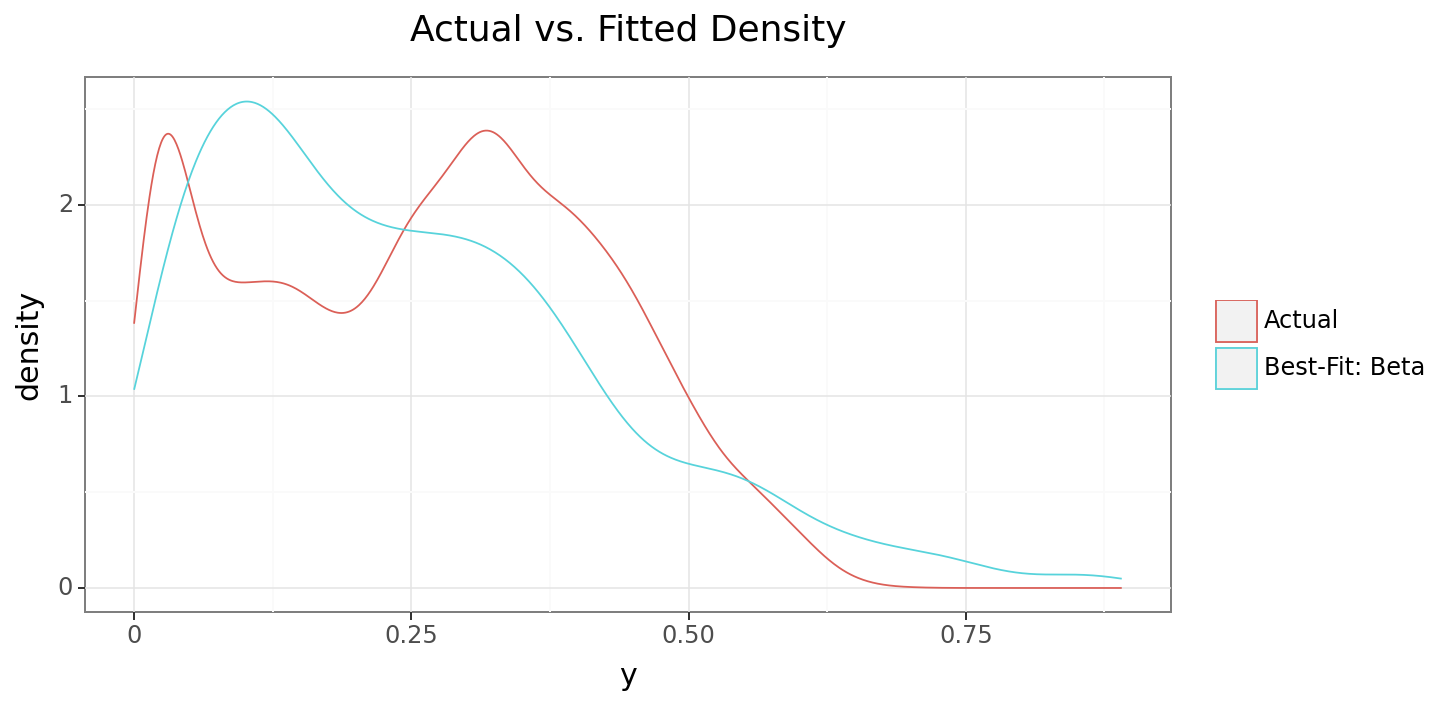

Fitting of candidate distributions completed: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


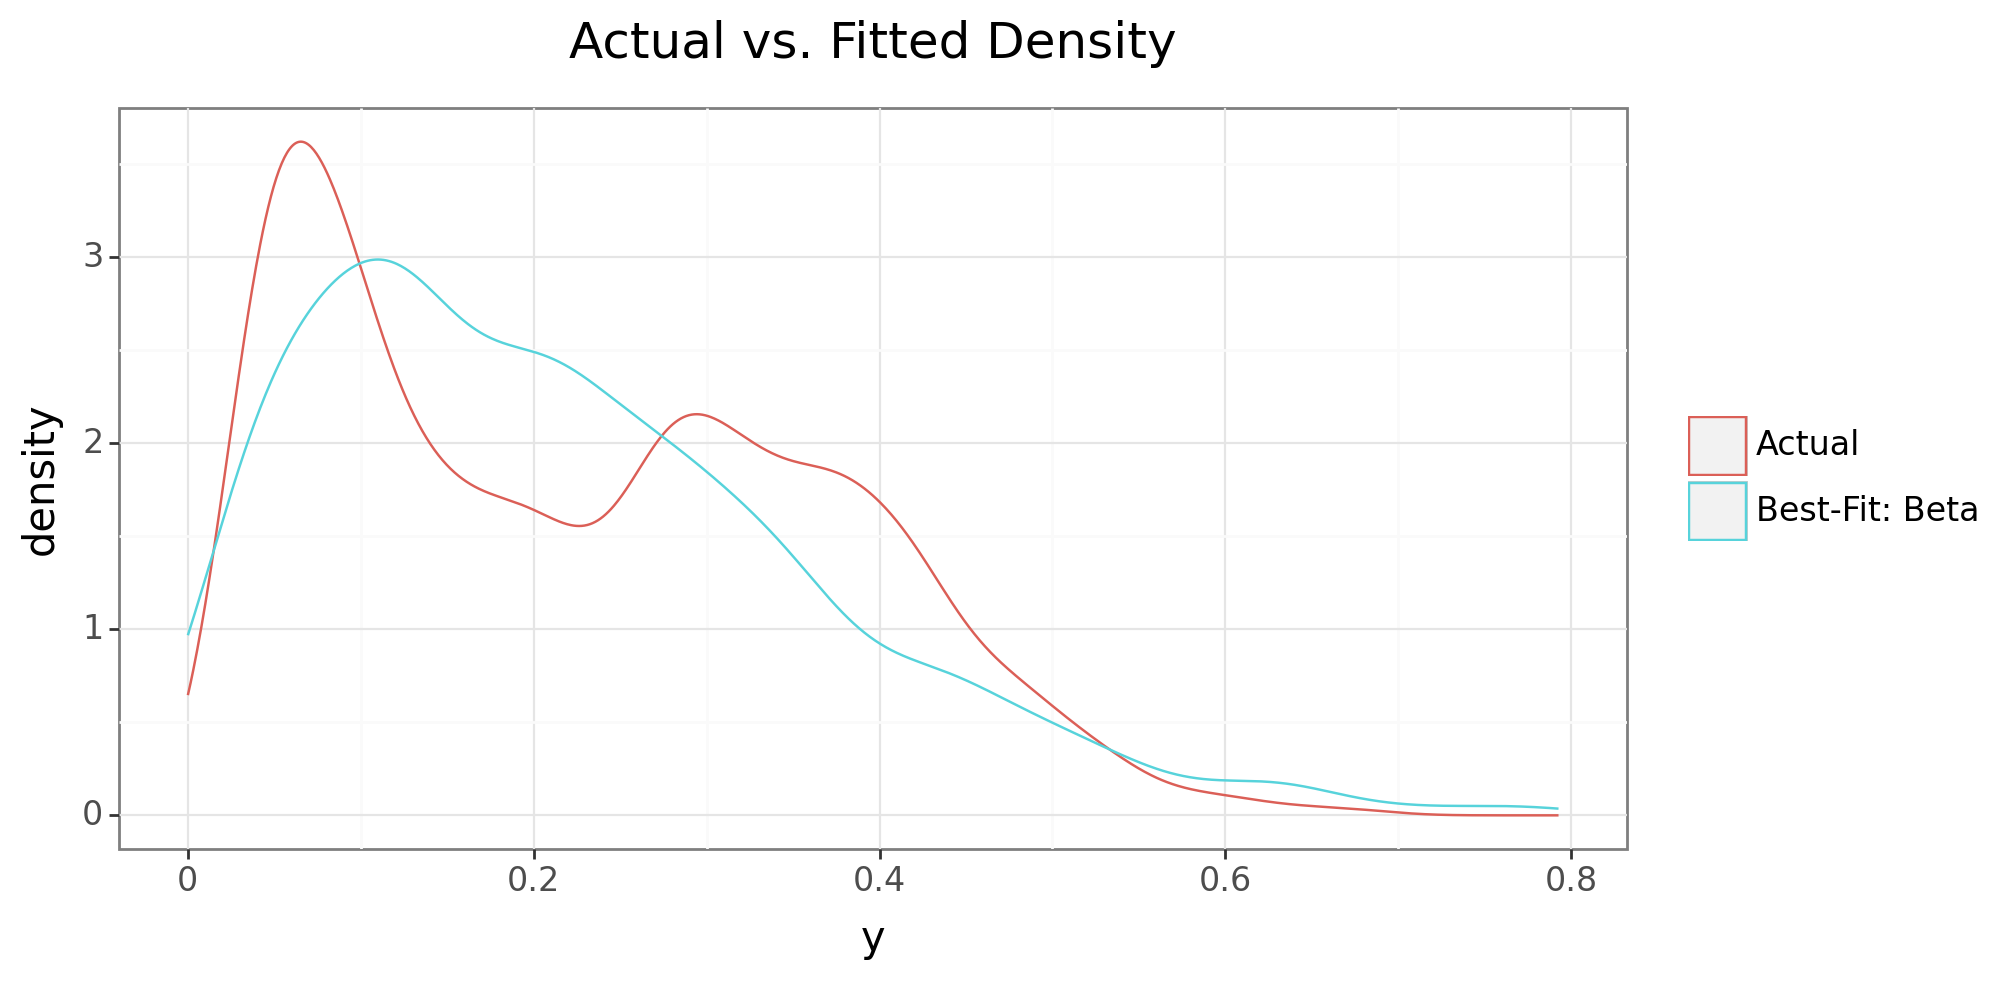

Fitting of candidate distributions completed: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


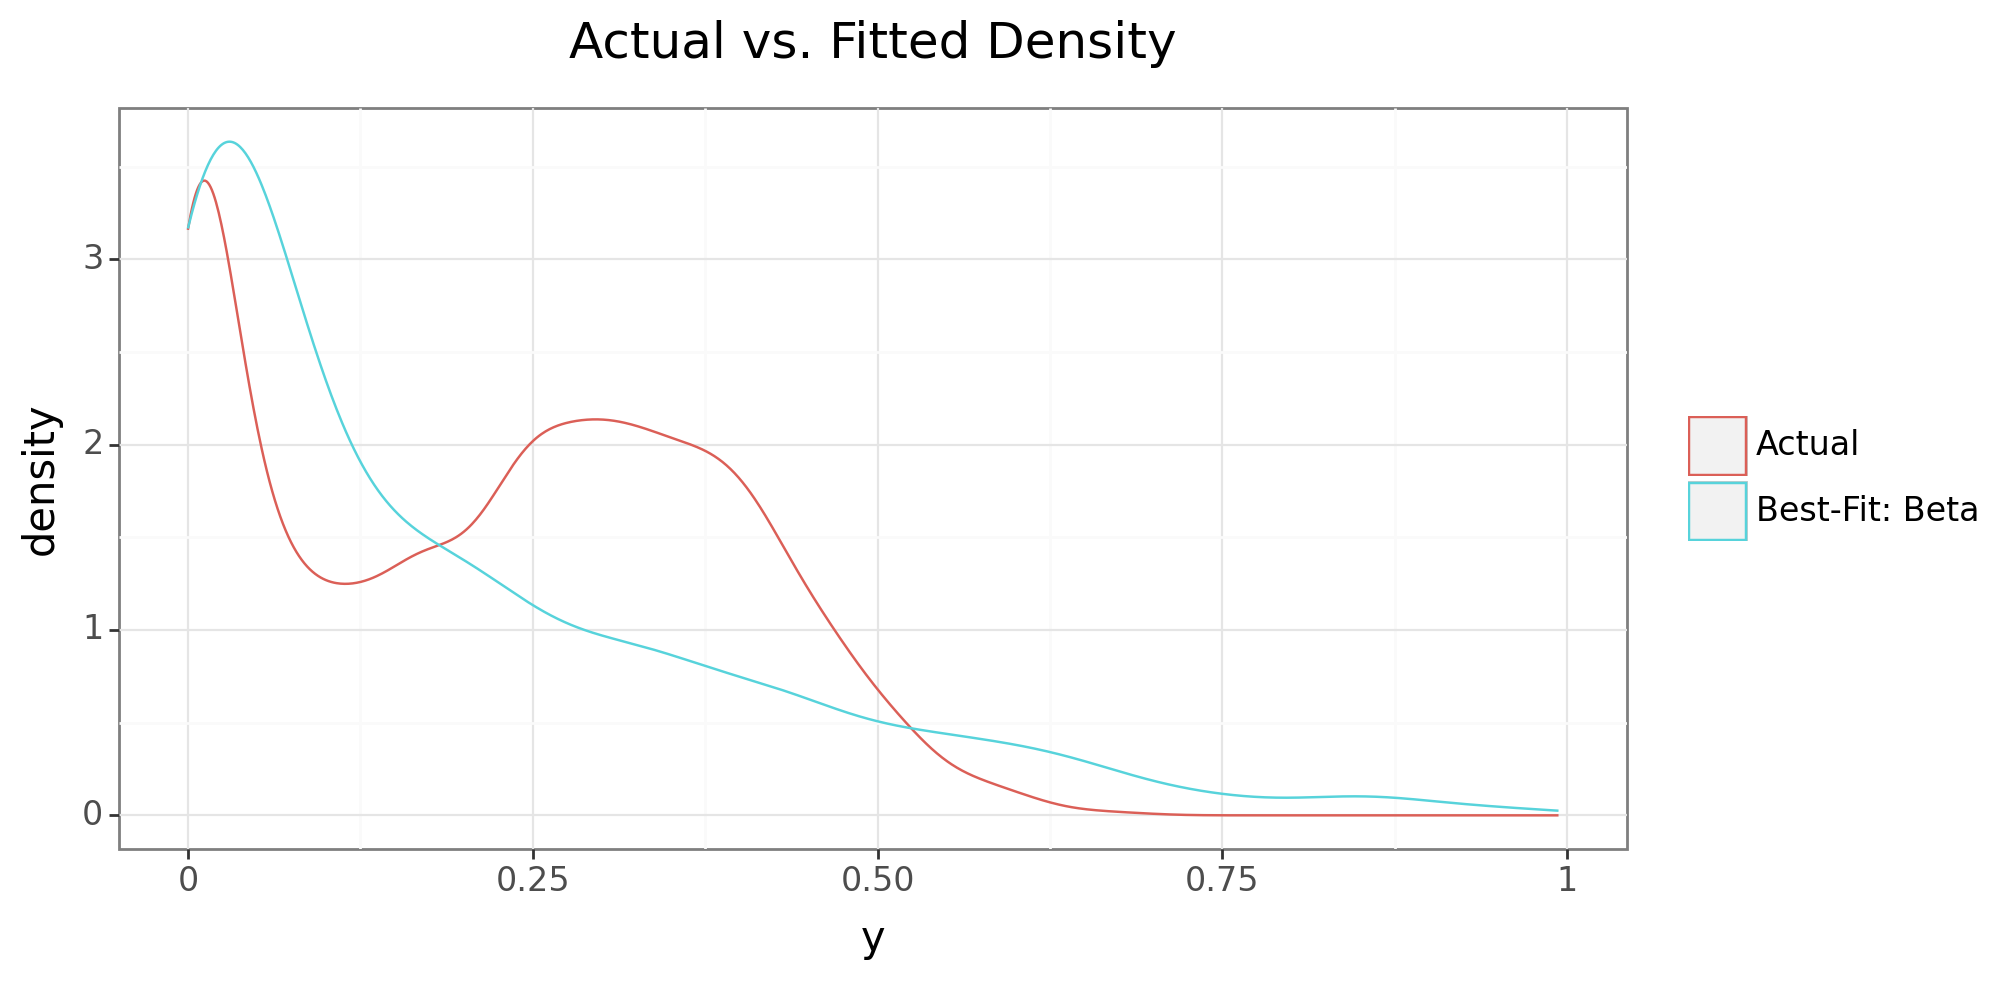

Fitting of candidate distributions completed: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


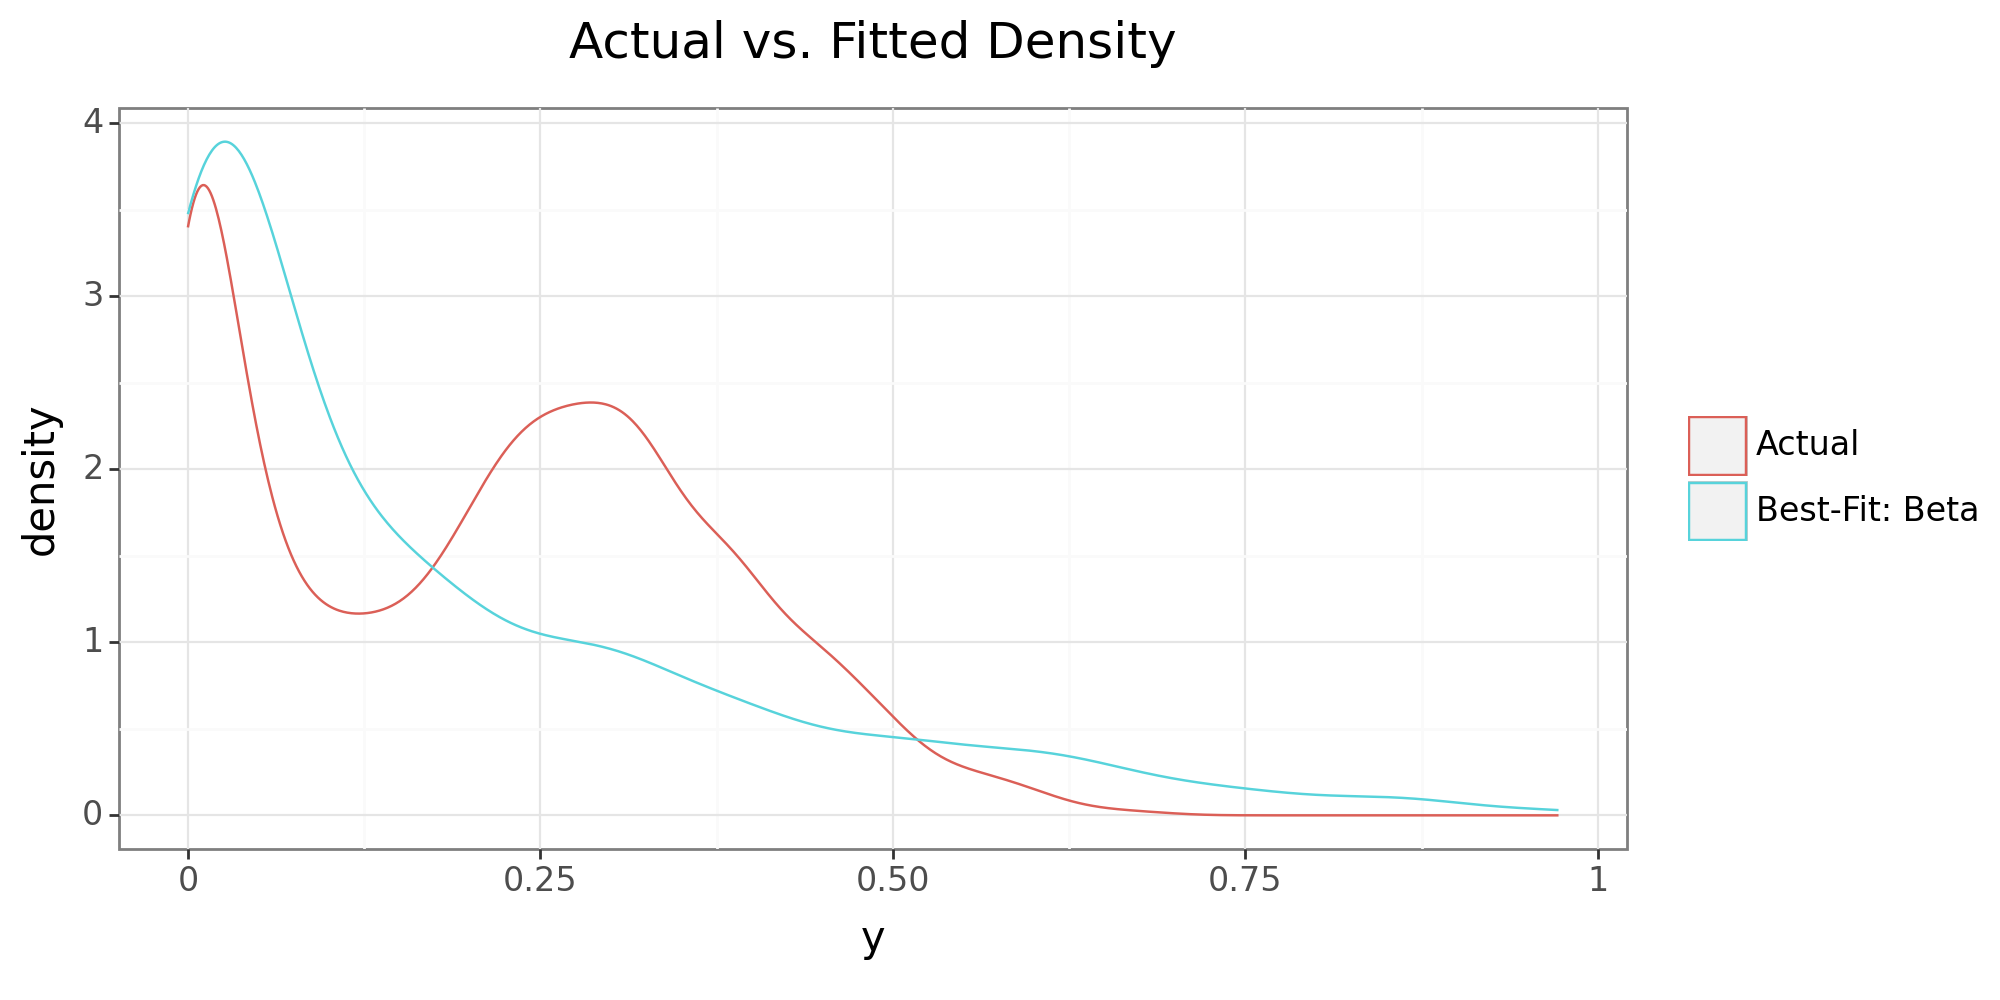

In [64]:
for building_id, period in anomaly_periods.items():
    Start_date = pd.Timestamp(period[0])
    End_date = pd.Timestamp(period[1])

    Test_Start = Start_date
    Train_End = Test_Start + DateOffset(days=-1)
    Train_Start = Test_Start + DateOffset(months=-12)
    Test_End = End_date
    Results_temp = pd.DataFrame()
    ds_build = ds[ds.ObjectName == building_id]
    X_train, X_test, Y_train, Y_test, Results_temp = Preprocessing(ds_build, Train_Start, Train_End, Test_Start, Test_End)
    candidate_distributions = [Gaussian, StudentT, Cauchy, LogNormal, Beta,Laplace]
    xgblss_dist_class = DistributionClass()
    dist_nll = xgblss_dist_class.dist_select(target=Y_train.values.ravel()+1e-05, candidate_distributions=candidate_distributions, max_iter=50, plot=True)

#### Optimize hyperparameters

In [11]:
# Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
        # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
            # param_name: str, Name of the parameter
            # value: int, Value of the parameter
        # Example: {"gpu_id": ["none", [0]]}

# Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are
# specified, max_depth is not used when gblinear is sampled, since it has no such argument.

param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
    }

def optimize_xgboost_hyperparameters(xgblss, dtrain, param_dict, train_pct=1.0, num_boost_round=300, nfold=5, early_stopping_rounds=20, max_minutes=2, n_trials=None, silence=False, seed=123, hp_seed=None):
    np.random.seed(seed)
    # Select a percentage of the training data to use for optimization
    train_size = int(train_pct * dtrain.num_row())
    train_indices = np.random.choice(dtrain.num_row(), train_size, replace=False)
    dtrain_subset = dtrain.slice(train_indices)
    opt_param_lss = xgblss.hyper_opt(param_dict,
                                 dtrain_subset,
                                 num_boost_round=num_boost_round,
                                 nfold=nfold,
                                 early_stopping_rounds=early_stopping_rounds,
                                 max_minutes=max_minutes,
                                 n_trials=n_trials,
                                 silence=silence,
                                 seed=seed,
                                 hp_seed=hp_seed
                                )
    return opt_param_lss

In [12]:
def train_xgboost_with_optimized_hyperparameters(dtrain, opt_params_lss,xgblss):
    opt_params = opt_params_lss.copy()
    n_rounds = opt_params["opt_rounds"]
    del opt_params["opt_rounds"]

    # Train Model with optimized hyperparameters
    xgblss.train(opt_params,
                 dtrain,
                 num_boost_round=n_rounds
                 )
    return xgblss

#### Train

In [13]:
Results_LSS = pd.DataFrame()
n_cpu = multiprocessing.cpu_count()
distribution=Beta.Beta 
train_pct = 0.3
for building_id, period in anomaly_periods.items():
    Start_date = pd.Timestamp(period[0])
    End_date = pd.Timestamp(period[1])

    Test_Start = Start_date
    Train_End = Test_Start + DateOffset(days=-1)
    Train_Start = Test_Start + DateOffset(months=-12)
    Test_End = End_date
    Results_temp = pd.DataFrame()
    ds_build = ds[ds.ObjectName == building_id]
    X_train, X_test, Y_train, Y_test, Results_temp = Preprocessing(ds_build, Train_Start, Train_End, Test_Start, Test_End)
    if X_train.empty or X_test.empty or Y_train.empty or Y_test.empty:
        continue
    if Y_train.empty:
        continue
    num_decimal_points = -int(np.log10(Y_train.target.describe()['std']))
    if num_decimal_points > 1:
        Y_train *= 100
        Y_test *= 100
        Results_temp[['Consumption']] *= 100

    
    xgblss = XGBoostLSS(distribution(stabilization="MAD",  
          response_fn="softplus")      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
    )
    dtrain = xgb.DMatrix(X_train, label=Y_train.values.ravel()+1e-05, nthread=n_cpu)
    
    #uncomment this if you want to optimize hyperparameters
    #opt_params_lss = optimize_xgboost_hyperparameters(xgblss, dtrain, param_dict, train_pct, num_boost_round=500, nfold=5, early_stopping_rounds=10, max_minutes=5, n_trials=None, silence=False, seed=123, hp_seed=None)
    xgblss = train_xgboost_with_optimized_hyperparameters(dtrain, opt_params_lss, xgblss)

    
    dtest = xgb.DMatrix(X_test, nthread=n_cpu)
    pred_quantiles = xgblss.predict(dtest,
                                    pred_type="quantiles",
                                    quantiles=quantiles,
                                    seed=123)
    Results_temp['Predicted'] = pd.Series(np.expm1(pred_quantiles.iloc[:, 1]))
    Results_temp['Lower bound'] = pd.Series(np.expm1(pred_quantiles.iloc[:, 0]))
    Results_temp['Upper bound'] = pd.Series(np.expm1(pred_quantiles.iloc[:, 2]))

    Results_LSS = pd.concat([Results_LSS, Results_temp], axis=0)

##  Results

In [16]:
def alarm_day_performance(df1):
 
    df1['date'] = df1['Date'].dt.date


    days = df1.loc[(df1['alarm_daily'])|(df1['alarm_weekly']).eq(1), 'date']
    df1['alarm_thatday'] = df1['date'].isin(days).astype(int)
    days_anomal=df1.loc[(df1['m_bool']).eq(1), 'date']
    df1['anomal_thatday'] = df1['date'].isin(days_anomal).astype(int)
    return df1


def evaluate_model_performance(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
                               'Value': [accuracy, precision, recall, f1, roc_auc]}).set_index('Metric')
    
    return metrics_df, conf_matrix


def compute_coverage_len(y_test, y_lower, y_upper, verbose=False, eta=30, mu=0.9):

    in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
    coverage = in_the_range / np.prod(y_test.shape)
    avg_length = np.mean(abs(y_upper - y_lower))
    avg_length = avg_length/(y_test.max()-y_test.min())
    cwc = (1-avg_length)*np.exp(-eta*(coverage-mu)**2)
    if verbose==True:
        print(f"PI coverage: {coverage*100:.1f}%, PI avg. length: {avg_length:.3f}, CWC: {cwc:.3f}")
    else:
        return coverage, avg_length, cwc

### XGBoostLSS results

In [17]:
Alarms_LSS=alarm_matrix_new.Alarm_matrix(Results_LSS)
fig=Visualization(Alarms_LSS)
fig.update_layout(showlegend=False, template='plotly_white', title='XGBoostLSS basic',height=1500)
fig.show()
compute_coverage_len(Alarms_LSS['Consumption'], Alarms_LSS['Lower bound'], Alarms_LSS['Upper bound'], verbose=True)

Alarms_LSS_back=alarm_matrix_new_withbackprop.Alarm_matrix(Results_LSS)
matrix=alarm_day_performance(Alarms_LSS_back)
metrix_df,conf_matrix=evaluate_model_performance(matrix['anomal_thatday'], matrix['alarm_thatday'])
metrix_df.round(2)


PI coverage: 76.5%, PI avg. length: 0.130, CWC: 0.503


,Value
Metric,
Accuracy,0.77
Precision,0.60
Recall,0.96
F1-score,0.74
ROC-AUC,0.82


### EnbPI results

In [18]:
Alarms_EnbPI=alarm_matrix_new.Alarm_matrix(Results_EnbPI)
fig=Visualization(Alarms_EnbPI)
fig.update_layout(showlegend=False, template='plotly_white', title='EnbPI basic',height=1500)
fig.show()
compute_coverage_len(Alarms_EnbPI['Consumption'], Alarms_EnbPI['Lower bound'], Alarms_EnbPI['Upper bound'], verbose=True)

Alarms_EnbPI_back=alarm_matrix_new_withbackprop.Alarm_matrix(Results_EnbPI)
matrix=alarm_day_performance(Alarms_EnbPI_back)
metrix_df,conf_matrix=evaluate_model_performance(matrix['anomal_thatday'], matrix['alarm_thatday'])
metrix_df.round(2)


PI coverage: 70.7%, PI avg. length: 0.084, CWC: 0.299


,Value
Metric,
Accuracy,0.56
Precision,0.43
Recall,0.99
F1-score,0.60
ROC-AUC,0.66
